In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

In [ ]:
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


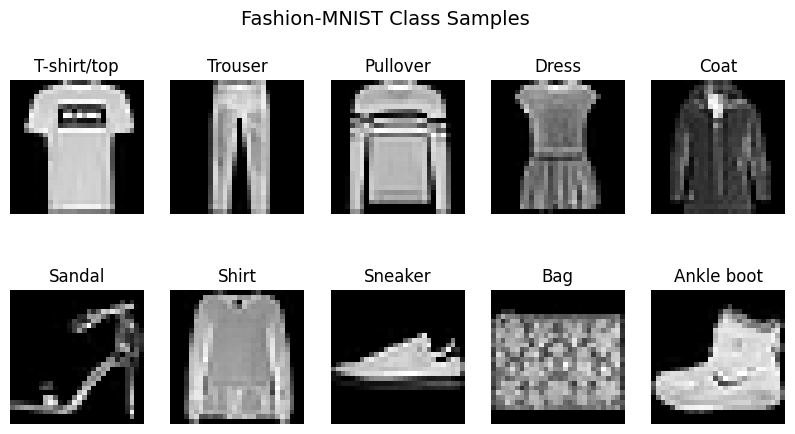

In [ ]:
# Class names in Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Select one sample from each class
unique_classes = np.unique(train_labels)
sample_images = []
for cls in unique_classes:
    # the first occurence of each class
    index = np.where(train_labels == cls)[0][0]
    sample_images.append(train_images[index])

# Plot the images in grid format
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Fashion-MNIST Class Samples", fontsize=14)

for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i], cmap='gray')
    ax.set_title(class_names[i])
    ax.axis('off')

plt.show()

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs24m035 (cs24m035-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

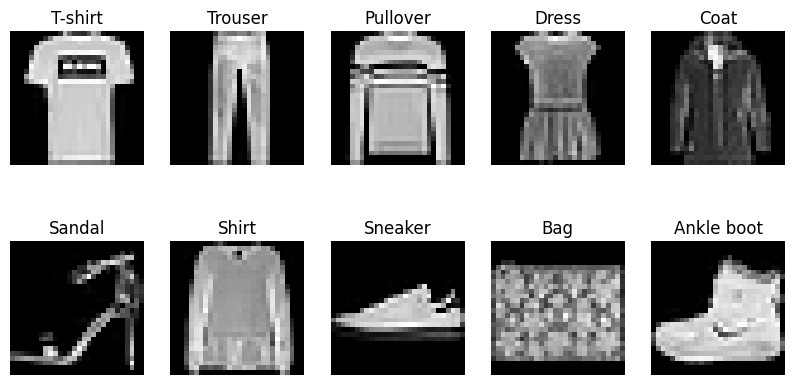

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

# Load Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize images
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

split_index = int(0.9 * x_train.shape[0])
x_train, x_val = x_train[:split_index], x_train[split_index:]
y_train, y_val = y_train[:split_index], y_train[split_index:]

# One-hot encoding labels
def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_ohe = one_hot_encode(y_train)
y_val_ohe = one_hot_encode(y_val)
y_test_ohe = one_hot_encode(y_test)

# Display one sample per class
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
labels = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

for i in range(10):
    ax = axes[i // 5, i % 5]
    idx = np.where(y_train == i)[0][0]
    ax.imshow(x_train[idx].reshape(28, 28), cmap='gray')
    ax.set_title(labels[i])
    ax.axis('off')
plt.show()

# Define Neural Network class
class NeuralNetwork:
    def __init__(self, layers, learning_rate=0.01, optimizer="sgd", weight_decay=0.0, weight_init="random", activation="relu"):
        self.layers = layers
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.weight_decay = weight_decay
        self.weight_init = weight_init
        self.activation = activation
        self.initialize_weights()

    def initialize_weights(self):
        self.weights = []
        self.biases = []

        for i in range(len(self.layers) - 1):
            if self.weight_init == "xavier":
                limit = np.sqrt(6 / (self.layers[i] + self.layers[i+1]))
                self.weights.append(np.random.uniform(-limit, limit, (self.layers[i], self.layers[i+1])))
            else:
                self.weights.append(np.random.randn(self.layers[i], self.layers[i+1]) * 0.01)

            self.biases.append(np.zeros((1, self.layers[i+1])))

        self.velocities_w = [np.zeros_like(w) for w in self.weights]
        self.velocities_b = [np.zeros_like(b) for b in self.biases]
        self.m_w, self.v_w = [np.zeros_like(w) for w in self.weights], [np.zeros_like(w) for w in self.weights]
        self.m_b, self.v_b = [np.zeros_like(b) for b in self.biases], [np.zeros_like(b) for b in self.biases]
        self.t = 1

    def relu(self, x):
        return np.maximum(0, x)

    def tanh(self, x):
        return np.tanh(x)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def activate(self, x):
        if self.activation == "tanh":
            return self.tanh(x)
        if self.activation == "sigmoid":
            return self.sigmoid(x)
        if self.activation == "relu":
            return self.relu(x)

    def forward(self, x):
        self.activations = [x]
        for i in range(len(self.weights) - 1):
            x = self.relu(np.dot(x, self.weights[i]) + self.biases[i])
            self.activations.append(x)
        x = self.softmax(np.dot(x, self.weights[-1]) + self.biases[-1])
        self.activations.append(x)
        return x

    def backward(self, x, y):
        m = y.shape[0]
        grads_w = [np.zeros_like(w) for w in self.weights]
        grads_b = [np.zeros_like(b) for b in self.biases]

        dz = self.activations[-1] - y

        for i in reversed(range(len(self.weights))):
            grads_w[i] = np.dot(self.activations[i].T, dz) / m
            grads_b[i] = np.sum(dz, axis=0, keepdims=True) / m

            if i > 0:
                dz = np.dot(dz, self.weights[i].T) * (self.activations[i] > 0)

        self.update_weights(grads_w, grads_b)

    def update_weights(self, grads_w, grads_b):
        if self.optimizer == "sgd":
            for i in range(len(self.weights)):
                self.weights[i] -= self.learning_rate * grads_w[i]
                self.biases[i] -= self.learning_rate * grads_b[i]
        elif self.optimizer == "momentum":
            gamma = 0.9
            for i in range(len(self.weights)):
                self.velocities_w[i] = gamma * self.velocities_w[i] + self.learning_rate * grads_w[i]
                self.weights[i] -= self.velocities_w[i]
                self.velocities_b[i] = gamma * self.velocities_b[i] + self.learning_rate * grads_b[i]
                self.biases[i] -= self.velocities_b[i]
        elif self.optimizer == "nesterov":
            gamma = 0.9
            for i in range(len(self.weights)):
                v_prev = self.velocities_w[i]
                self.velocities_w[i] = gamma * self.velocities_w[i] + self.learning_rate * grads_w[i]
                self.weights[i] -= gamma * v_prev + (1 + gamma) * self.velocities_w[i]
        elif self.optimizer == "rmsprop":
            beta = 0.9
            for i in range(len(self.weights)):
                self.v_w[i] = beta * self.v_w[i] + (1 - beta) * grads_w[i] ** 2
                self.weights[i] -= self.learning_rate * grads_w[i] / (np.sqrt(self.v_w[i]) + 1e-8)
        elif self.optimizer == "adam":
            beta1, beta2 = 0.9, 0.999
            for i in range(len(self.weights)):
                self.m_w[i] = beta1 * self.m_w[i] + (1 - beta1) * grads_w[i]
                self.v_w[i] = beta2 * self.v_w[i] + (1 - beta2) * grads_w[i] ** 2
                m_hat = self.m_w[i] / (1 - beta1 ** self.t)
                v_hat = self.v_w[i] / (1 - beta2 ** self.t)
                self.weights[i] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + 1e-8)
        elif self.optimizer == "nadam":
            beta1, beta2 = 0.9, 0.999
            for i in range(len(self.weights)):
                self.m_w[i] = beta1 * self.m_w[i] + (1 - beta1) * grads_w[i]
                self.v_w[i] = beta2 * self.v_w[i] + (1 - beta2) * grads_w[i] ** 2
                m_hat = self.m_w[i] / (1 - beta1 ** self.t)
                v_hat = self.v_w[i] / (1 - beta2 ** self.t)
                self.weights[i] -= self.learning_rate * (beta1 * m_hat + (1 - beta1) * grads_w[i] / (1 - beta1 ** self.t)) / (np.sqrt(v_hat) + 1e-8)
        self.t += 1

    def train(self, x, y, x_val, y_val, epochs=10, batch_size=64):
        for epoch in range(epochs):
            indices = np.arange(x.shape[0])
            np.random.shuffle(indices)
            x, y = x[indices], y[indices]

            for i in range(0, x.shape[0], batch_size):
                x_batch = x[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                y_pred = self.forward(x_batch)
                self.backward(x_batch, y_batch)

            y_pred_val = self.forward(x_val)
            val_loss = -np.mean(np.sum(y_val * np.log(y_pred_val + 1e-8), axis=1))
            wandb.log({"Validation Loss": val_loss})
            print(f"Epoch {epoch+1}/{epochs}, Loss: {val_loss:.4f}")


    def evaluate(self, x, y):
        y_pred = self.forward(x)
        accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1))
        print(f"Test Accuracy: {accuracy * 100:.2f}%")





In [ ]:
# Train and evaluate the model
nn = NeuralNetwork(layers=[784, 128, 64, 10], learning_rate=0.01, optimizer="nadam")
nn.train(x_train, y_train_ohe, x_val, y_val_ohe, epochs=10, batch_size=64)
nn.evaluate(x_test, y_test_ohe)

Epoch 1/10, Loss: 0.4211
Epoch 2/10, Loss: 0.4139
Epoch 3/10, Loss: 0.3898
Epoch 4/10, Loss: 0.4107
Epoch 5/10, Loss: 0.3972
Epoch 6/10, Loss: 0.3802
Epoch 7/10, Loss: 0.3837
Epoch 8/10, Loss: 0.3693
Epoch 9/10, Loss: 0.4027
Epoch 10/10, Loss: 0.3634
Test Accuracy: 86.65%


In [ ]:
def train_sweep():
    wandb.init()
    config = wandb.config

    model = NeuralNetwork(
        layers=[784] + [config.layer_size] * config.hidden_layers + [10],
        learning_rate=config.learning_rate,
        optimizer=config.optimizer,
        weight_decay=config.weight_decay,
        weight_init=config.weight_init,
        activation=config.activation
    )
    model.train(x_train, y_train_ohe, x_val, y_val_ohe, epochs=config.epochs, batch_size=config.batch_size)

In [ ]:
sweep_config = {
    "method": "random",
    "metric": {"name": "Validation Loss", "goal": "minimize"},
    "parameters": {
        "epochs": {"values": [5, 10]},
        "hidden_layers": {"values": [3, 4, 5]},
        "layer_size": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "weight_init": {"values": ["random", "xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "relu"]}
    }
}
sweep_id = wandb.sweep(sweep_config, project="fashion-mnist-nn")
wandb.agent(sweep_id, function=train_sweep)

Create sweep with ID: fcnhyp4c
Sweep URL: https://wandb.ai/cs24m035-indian-institute-of-technology-madras/fashion-mnist-nn/sweeps/fcnhyp4c


wandb: Agent Starting Run: cnrndydx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch 1/10, Loss: 2.3026
Epoch 2/10, Loss: 2.3026
Epoch 3/10, Loss: 2.3026
Epoch 4/10, Loss: 2.3026
Epoch 5/10, Loss: 2.3026
Epoch 6/10, Loss: 2.3027
Epoch 7/10, Loss: 2.3027
Epoch 8/10, Loss: 2.3027
Epoch 9/10, Loss: 2.3027
Epoch 10/10, Loss: 2.3027


wandb: Agent Starting Run: p5iuypyf with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5, Loss: 0.5666
Epoch 2/5, Loss: 0.4851
Epoch 3/5, Loss: 0.4467
Epoch 4/5, Loss: 0.4289
Epoch 5/5, Loss: 0.4209


wandb: Agent Starting Run: 8j6ta1io with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/5, Loss: 1.0502
Epoch 2/5, Loss: 0.9809
Epoch 3/5, Loss: 0.9426
Epoch 4/5, Loss: 0.9133
Epoch 5/5, Loss: 0.8900


wandb: Agent Starting Run: c3og2dw0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/10, Loss: 2.3026
Epoch 2/10, Loss: 2.3026
Epoch 3/10, Loss: 2.3026
Epoch 4/10, Loss: 2.3026
Epoch 5/10, Loss: 2.3026
Epoch 6/10, Loss: 2.3026
Epoch 7/10, Loss: 2.3026
Epoch 8/10, Loss: 2.3026
Epoch 9/10, Loss: 2.3026
Epoch 10/10, Loss: 2.3026


wandb: Agent Starting Run: tdy1m7ha with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/5, Loss: 2.3026
Epoch 2/5, Loss: 2.3026
Epoch 3/5, Loss: 2.3026
Epoch 4/5, Loss: 2.3026
Epoch 5/5, Loss: 2.3026


wandb: Agent Starting Run: egwc4shw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5, Loss: 2.1761
Epoch 2/5, Loss: 2.0095
Epoch 3/5, Loss: 1.7863
Epoch 4/5, Loss: 1.5181
Epoch 5/5, Loss: 1.2838


wandb: Agent Starting Run: sgrvoevg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10, Loss: 2.2768
Epoch 2/10, Loss: 2.2455
Epoch 3/10, Loss: 2.2155
Epoch 4/10, Loss: 2.1781
Epoch 5/10, Loss: 2.1309
Epoch 6/10, Loss: 2.0802
Epoch 7/10, Loss: 2.0253
Epoch 8/10, Loss: 1.9671
Epoch 9/10, Loss: 1.9081
Epoch 10/10, Loss: 1.8490


wandb: Agent Starting Run: dqi8czue with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/5, Loss: 2.3026
Epoch 2/5, Loss: 2.3026
Epoch 3/5, Loss: 2.3026
Epoch 4/5, Loss: 2.3026
Epoch 5/5, Loss: 2.3026


wandb: Agent Starting Run: nk24bekc with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5, Loss: 0.9391
Epoch 2/5, Loss: 0.7946
Epoch 3/5, Loss: 0.7708
Epoch 4/5, Loss: 0.6940
Epoch 5/5, Loss: 0.6495


wandb: Agent Starting Run: 5i2xpt1j with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5, Loss: 2.2531
Epoch 2/5, Loss: 2.1994
Epoch 3/5, Loss: 2.1290
Epoch 4/5, Loss: 2.0396
Epoch 5/5, Loss: 1.9311


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7ili5m0l with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/5, Loss: 2.3026
Epoch 2/5, Loss: 2.3027
Epoch 3/5, Loss: 2.3030
Epoch 4/5, Loss: 2.3031
Epoch 5/5, Loss: 2.3031


wandb: Agent Starting Run: b8feip3w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5, Loss: 2.3026
Epoch 2/5, Loss: 2.3026
Epoch 3/5, Loss: 2.3026
Epoch 4/5, Loss: 2.3026
Epoch 5/5, Loss: 2.3027


wandb: Agent Starting Run: r1lkymlc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/10, Loss: 2.3026
Epoch 2/10, Loss: 2.3026
Epoch 3/10, Loss: 2.3026
Epoch 4/10, Loss: 2.3026
Epoch 5/10, Loss: 2.3027
Epoch 6/10, Loss: 2.3027
Epoch 7/10, Loss: 2.3027
Epoch 8/10, Loss: 2.3027
Epoch 9/10, Loss: 2.3027
Epoch 10/10, Loss: 2.3027


wandb: Agent Starting Run: agkkz8ir with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10, Loss: 0.6161
Epoch 2/10, Loss: 0.5370
Epoch 3/10, Loss: 0.4973
Epoch 4/10, Loss: 0.4698
Epoch 5/10, Loss: 0.4686
Epoch 6/10, Loss: 0.4370
Epoch 7/10, Loss: 0.4227
Epoch 8/10, Loss: 0.4254
Epoch 9/10, Loss: 0.4017
Epoch 10/10, Loss: 0.3964


wandb: Agent Starting Run: zqcs5xmw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/5, Loss: 0.9294
Epoch 2/5, Loss: 0.8565
Epoch 3/5, Loss: 0.8055
Epoch 4/5, Loss: 0.7893
Epoch 5/5, Loss: 0.7110


wandb: Agent Starting Run: 2uxur7yd with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/5, Loss: 0.8594
Epoch 2/5, Loss: 0.7589
Epoch 3/5, Loss: 0.6814
Epoch 4/5, Loss: 0.6620
Epoch 5/5, Loss: 0.5819


wandb: Agent Starting Run: cqcqwpip with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5, Loss: 0.4854
Epoch 2/5, Loss: 0.4414
Epoch 3/5, Loss: 0.4088
Epoch 4/5, Loss: 0.3904
Epoch 5/5, Loss: 0.3914


wandb: Agent Starting Run: pdbhwrt9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5, Loss: 0.9044
Epoch 2/5, Loss: 0.7096
Epoch 3/5, Loss: 0.6340
Epoch 4/5, Loss: 0.5932
Epoch 5/5, Loss: 0.5628


wandb: Agent Starting Run: 24d9b4et with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10, Loss: 0.7937
Epoch 2/10, Loss: 0.6204
Epoch 3/10, Loss: 0.5532
Epoch 4/10, Loss: 0.5159
Epoch 5/10, Loss: 0.4861
Epoch 6/10, Loss: 0.4720
Epoch 7/10, Loss: 0.4539
Epoch 8/10, Loss: 0.4454
Epoch 9/10, Loss: 0.4313
Epoch 10/10, Loss: 0.4315


wandb: Agent Starting Run: 1mhxd1oy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10, Loss: 0.3874
Epoch 2/10, Loss: 0.3882
Epoch 3/10, Loss: 0.3685
Epoch 4/10, Loss: 0.3533
Epoch 5/10, Loss: 0.3840
Epoch 6/10, Loss: 0.3403
Epoch 7/10, Loss: 0.3496
Epoch 8/10, Loss: 0.3495
Epoch 9/10, Loss: 0.3491
Epoch 10/10, Loss: 0.3696


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ge13naec with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10, Loss: 1.3431
Epoch 2/10, Loss: 0.8961
Epoch 3/10, Loss: 0.7826
Epoch 4/10, Loss: 0.7146
Epoch 5/10, Loss: 0.6599
Epoch 6/10, Loss: 0.6243
Epoch 7/10, Loss: 0.5920
Epoch 8/10, Loss: 0.5780
Epoch 9/10, Loss: 0.5544
Epoch 10/10, Loss: 0.5359


wandb: Agent Starting Run: w7of1llh with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10, Loss: 0.4462
Epoch 2/10, Loss: 0.4191
Epoch 3/10, Loss: 0.3937
Epoch 4/10, Loss: 0.3891
Epoch 5/10, Loss: 0.4144
Epoch 6/10, Loss: 0.3622
Epoch 7/10, Loss: 0.3585
Epoch 8/10, Loss: 0.3761
Epoch 9/10, Loss: 0.3703
Epoch 10/10, Loss: 0.3594


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: degh4v00 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/10, Loss: 0.5549
Epoch 2/10, Loss: 0.4704
Epoch 3/10, Loss: 0.4326
Epoch 4/10, Loss: 0.4108
Epoch 5/10, Loss: 0.3781
Epoch 6/10, Loss: 0.3698
Epoch 7/10, Loss: 0.3621
Epoch 8/10, Loss: 0.3476
Epoch 9/10, Loss: 0.3541
Epoch 10/10, Loss: 0.3947


wandb: Agent Starting Run: xo2p4cv9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/10, Loss: 0.8424
Epoch 2/10, Loss: 0.6796
Epoch 3/10, Loss: 0.5538
Epoch 4/10, Loss: 0.5537
Epoch 5/10, Loss: 0.4514
Epoch 6/10, Loss: 0.4591
Epoch 7/10, Loss: 0.4644
Epoch 8/10, Loss: 0.4146
Epoch 9/10, Loss: 0.3962
Epoch 10/10, Loss: 0.3988


wandb: Agent Starting Run: mya2mb4l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/10, Loss: 0.5837
Epoch 2/10, Loss: 0.4482
Epoch 3/10, Loss: 0.4422
Epoch 4/10, Loss: 0.3780
Epoch 5/10, Loss: 0.3923
Epoch 6/10, Loss: 0.3509
Epoch 7/10, Loss: 0.3488
Epoch 8/10, Loss: 0.3714
Epoch 9/10, Loss: 0.3365
Epoch 10/10, Loss: 0.3409


wandb: Agent Starting Run: 6oxaa0nt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5, Loss: 0.4586
Epoch 2/5, Loss: 0.4197
Epoch 3/5, Loss: 0.3941
Epoch 4/5, Loss: 0.3883
Epoch 5/5, Loss: 0.3597


wandb: Agent Starting Run: 9g15869l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5, Loss: 0.4847
Epoch 2/5, Loss: 0.3840
Epoch 3/5, Loss: 0.4384
Epoch 4/5, Loss: 0.3612
Epoch 5/5, Loss: 0.3653


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f2792ki8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5, Loss: 2.3026
Epoch 2/5, Loss: 2.3026
Epoch 3/5, Loss: 2.3027
Epoch 4/5, Loss: 2.3027
Epoch 5/5, Loss: 2.3027


wandb: Agent Starting Run: 54wn4id5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5, Loss: 0.5186
Epoch 2/5, Loss: 0.4531
Epoch 3/5, Loss: 0.4235
Epoch 4/5, Loss: 0.3975
Epoch 5/5, Loss: 0.3875


wandb: Agent Starting Run: vcm8lti4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/5, Loss: 2.3026
Epoch 2/5, Loss: 2.3026
Epoch 3/5, Loss: 2.3026
Epoch 4/5, Loss: 2.3026
Epoch 5/5, Loss: 2.3026


wandb: Agent Starting Run: a28tx400 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5, Loss: 0.6249
Epoch 2/5, Loss: 0.5181
Epoch 3/5, Loss: 0.4811
Epoch 4/5, Loss: 0.4452
Epoch 5/5, Loss: 0.4363


wandb: Agent Starting Run: pvqdb4er with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/10, Loss: 2.3026
Epoch 2/10, Loss: 2.3026
Epoch 3/10, Loss: 2.3027
Epoch 4/10, Loss: 2.3027
Epoch 5/10, Loss: 2.3027
Epoch 6/10, Loss: 2.3027
Epoch 7/10, Loss: 2.3027
Epoch 8/10, Loss: 2.3027
Epoch 9/10, Loss: 2.3027
Epoch 10/10, Loss: 2.3027


wandb: Agent Starting Run: ah7uw7pm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/10, Loss: 2.3027
Epoch 2/10, Loss: 2.3027
Epoch 3/10, Loss: 2.3028
Epoch 4/10, Loss: 2.3028
Epoch 5/10, Loss: 2.3027
Epoch 6/10, Loss: 2.3028
Epoch 7/10, Loss: 2.3027
Epoch 8/10, Loss: 2.3027
Epoch 9/10, Loss: 2.3028
Epoch 10/10, Loss: 2.3029


wandb: Agent Starting Run: 87j5udcr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10, Loss: 0.8345
Epoch 2/10, Loss: 0.6685
Epoch 3/10, Loss: 0.6004
Epoch 4/10, Loss: 0.5461
Epoch 5/10, Loss: 0.5265
Epoch 6/10, Loss: 0.4922
Epoch 7/10, Loss: 0.4958
Epoch 8/10, Loss: 0.4643
Epoch 9/10, Loss: 0.4612
Epoch 10/10, Loss: 0.4559


wandb: Agent Starting Run: b0uvyksw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10, Loss: 0.6402
Epoch 2/10, Loss: 0.5285
Epoch 3/10, Loss: 0.4886
Epoch 4/10, Loss: 0.4690
Epoch 5/10, Loss: 0.4501
Epoch 6/10, Loss: 0.4307
Epoch 7/10, Loss: 0.4343
Epoch 8/10, Loss: 0.4137
Epoch 9/10, Loss: 0.4136
Epoch 10/10, Loss: 0.4030


wandb: Agent Starting Run: ijb8uc37 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5, Loss: 1.6185
Epoch 2/5, Loss: 0.9811
Epoch 3/5, Loss: 0.8016
Epoch 4/5, Loss: 0.7243
Epoch 5/5, Loss: 0.6808


wandb: Agent Starting Run: 4d8ggtiq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/10, Loss: 0.9302
Epoch 2/10, Loss: 0.8518
Epoch 3/10, Loss: 0.6791
Epoch 4/10, Loss: 0.6060
Epoch 5/10, Loss: 0.5402
Epoch 6/10, Loss: 0.4802
Epoch 7/10, Loss: 0.4311
Epoch 8/10, Loss: 0.4404
Epoch 9/10, Loss: 0.4111
Epoch 10/10, Loss: 0.4327


wandb: Agent Starting Run: eid0jw0r with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5, Loss: 0.4090
Epoch 2/5, Loss: 0.3752
Epoch 3/5, Loss: 0.3643
Epoch 4/5, Loss: 0.3586
Epoch 5/5, Loss: 0.3348


wandb: Agent Starting Run: petulgd2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/5, Loss: 0.9264
Epoch 2/5, Loss: 0.8282
Epoch 3/5, Loss: 0.7535
Epoch 4/5, Loss: 0.5480
Epoch 5/5, Loss: 0.5353


wandb: Agent Starting Run: d1ilit9y with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10, Loss: 0.7713
Epoch 2/10, Loss: 0.6227
Epoch 3/10, Loss: 0.5569
Epoch 4/10, Loss: 0.5303
Epoch 5/10, Loss: 0.5010
Epoch 6/10, Loss: 0.4834
Epoch 7/10, Loss: 0.4747
Epoch 8/10, Loss: 0.4502
Epoch 9/10, Loss: 0.4432
Epoch 10/10, Loss: 0.4369


wandb: Agent Starting Run: puyl8xde with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5, Loss: 0.5558
Epoch 2/5, Loss: 0.4813
Epoch 3/5, Loss: 0.4491
Epoch 4/5, Loss: 0.4297
Epoch 5/5, Loss: 0.4178


wandb: Agent Starting Run: 9pk4ald3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/5, Loss: 2.3029
Epoch 2/5, Loss: 2.3028
Epoch 3/5, Loss: 2.3029
Epoch 4/5, Loss: 2.3032
Epoch 5/5, Loss: 2.3030


wandb: Agent Starting Run: mc6rrbpc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/5, Loss: 1.0674
Epoch 2/5, Loss: 0.9404
Epoch 3/5, Loss: 0.9502
Epoch 4/5, Loss: 0.9066
Epoch 5/5, Loss: 0.8832


wandb: Agent Starting Run: gr3ntjts with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5, Loss: 0.4388
Epoch 2/5, Loss: 0.4865
Epoch 3/5, Loss: 0.4146
Epoch 4/5, Loss: 0.4452
Epoch 5/5, Loss: 0.4642


wandb: Agent Starting Run: z4j4159v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5, Loss: 2.2010
Epoch 2/5, Loss: 2.0647
Epoch 3/5, Loss: 1.8639
Epoch 4/5, Loss: 1.6101
Epoch 5/5, Loss: 1.3585


wandb: Agent Starting Run: kv8odutz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/5, Loss: 2.3026
Epoch 2/5, Loss: 2.3026
Epoch 3/5, Loss: 2.3026
Epoch 4/5, Loss: 2.3026
Epoch 5/5, Loss: 2.3026


wandb: Agent Starting Run: tcjmcsm2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10, Loss: 1.4186
Epoch 2/10, Loss: 0.8343
Epoch 3/10, Loss: 0.7130
Epoch 4/10, Loss: 0.6511
Epoch 5/10, Loss: 0.6017
Epoch 6/10, Loss: 0.5712
Epoch 7/10, Loss: 0.5436
Epoch 8/10, Loss: 0.5407
Epoch 9/10, Loss: 0.5126
Epoch 10/10, Loss: 0.5057


wandb: Agent Starting Run: 4eb26vki with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5, Loss: 0.7885
Epoch 2/5, Loss: 0.6360
Epoch 3/5, Loss: 0.5636
Epoch 4/5, Loss: 0.5254
Epoch 5/5, Loss: 0.5279


wandb: Agent Starting Run: a4s9obb8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/10, Loss: 2.3026
Epoch 2/10, Loss: 2.3026
Epoch 3/10, Loss: 2.3026
Epoch 4/10, Loss: 2.3026
Epoch 5/10, Loss: 2.3027
Epoch 6/10, Loss: 2.3027
Epoch 7/10, Loss: 2.3027
Epoch 8/10, Loss: 2.3027
Epoch 9/10, Loss: 2.3027
Epoch 10/10, Loss: 2.3027


wandb: Agent Starting Run: 0csez0j9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5, Loss: 0.4863
Epoch 2/5, Loss: 0.4352
Epoch 3/5, Loss: 0.4184
Epoch 4/5, Loss: 0.3974
Epoch 5/5, Loss: 0.3797


wandb: Agent Starting Run: fceg8qlp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5, Loss: 1.7333
Epoch 2/5, Loss: 1.0696
Epoch 3/5, Loss: 0.8375
Epoch 4/5, Loss: 0.7513
Epoch 5/5, Loss: 0.7047


wandb: Agent Starting Run: 6gr564d3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5, Loss: 2.2900
Epoch 2/5, Loss: 2.2515
Epoch 3/5, Loss: 2.2133
Epoch 4/5, Loss: 2.1693
Epoch 5/5, Loss: 2.1158


wandb: Agent Starting Run: 0nwn7be5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5, Loss: 0.7949
Epoch 2/5, Loss: 0.6452
Epoch 3/5, Loss: 0.5724
Epoch 4/5, Loss: 0.5437
Epoch 5/5, Loss: 0.5087


wandb: Agent Starting Run: bg9hdlca with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5, Loss: 0.4820
Epoch 2/5, Loss: 0.4531
Epoch 3/5, Loss: 0.4861
Epoch 4/5, Loss: 0.4497
Epoch 5/5, Loss: 0.4439


wandb: Agent Starting Run: pxcuesfl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/10, Loss: 2.3027
Epoch 2/10, Loss: 2.3027
Epoch 3/10, Loss: 2.3027
Epoch 4/10, Loss: 2.3027
Epoch 5/10, Loss: 2.3028
Epoch 6/10, Loss: 2.3028
Epoch 7/10, Loss: 2.3028
Epoch 8/10, Loss: 2.3027
Epoch 9/10, Loss: 2.3027
Epoch 10/10, Loss: 2.3028


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: big3zbai with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10, Loss: 0.4875
Epoch 2/10, Loss: 0.4387
Epoch 3/10, Loss: 0.4567
Epoch 4/10, Loss: 0.3682
Epoch 5/10, Loss: 0.3936
Epoch 6/10, Loss: 0.3528
Epoch 7/10, Loss: 0.3774
Epoch 8/10, Loss: 0.3756
Epoch 9/10, Loss: 0.3487
Epoch 10/10, Loss: 0.3478


wandb: Agent Starting Run: 4xep74b5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10, Loss: 0.5547
Epoch 2/10, Loss: 0.4710
Epoch 3/10, Loss: 0.4645
Epoch 4/10, Loss: 0.4494
Epoch 5/10, Loss: 0.4217
Epoch 6/10, Loss: 0.4304
Epoch 7/10, Loss: 0.3777
Epoch 8/10, Loss: 0.3725
Epoch 9/10, Loss: 0.3611
Epoch 10/10, Loss: 0.3719


wandb: Agent Starting Run: ilaet6g3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/10, Loss: 1.0344
Epoch 2/10, Loss: 0.9699
Epoch 3/10, Loss: 0.9445
Epoch 4/10, Loss: 0.9140
Epoch 5/10, Loss: 0.8855
Epoch 6/10, Loss: 0.8638
Epoch 7/10, Loss: 0.8447
Epoch 8/10, Loss: 0.8295
Epoch 9/10, Loss: 0.8079
Epoch 10/10, Loss: 0.7894


wandb: Agent Starting Run: y9y8g1cs with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5, Loss: 0.4522
Epoch 2/5, Loss: 0.3976
Epoch 3/5, Loss: 0.3800
Epoch 4/5, Loss: 0.3764
Epoch 5/5, Loss: 0.3899


wandb: Agent Starting Run: dayoxcav with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1/10, Loss: 2.3026
Epoch 2/10, Loss: 2.3027
Epoch 3/10, Loss: 2.3027
Epoch 4/10, Loss: 2.3027
Epoch 5/10, Loss: 2.3027
Epoch 6/10, Loss: 2.3027
Epoch 7/10, Loss: 2.3028
Epoch 8/10, Loss: 2.3028
Epoch 9/10, Loss: 2.3028
Epoch 10/10, Loss: 2.3028


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mbomnvdk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10, Loss: 0.8443
Epoch 2/10, Loss: 0.7047
Epoch 3/10, Loss: 0.6169
Epoch 4/10, Loss: 0.5860
Epoch 5/10, Loss: 0.5591
Epoch 6/10, Loss: 0.5236
Epoch 7/10, Loss: 0.5053
Epoch 8/10, Loss: 0.5034
Epoch 9/10, Loss: 0.4924
Epoch 10/10, Loss: 0.4663


wandb: Agent Starting Run: le313aq7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5, Loss: 0.4753
Epoch 2/5, Loss: 0.4336
Epoch 3/5, Loss: 0.3854
Epoch 4/5, Loss: 0.3779
Epoch 5/5, Loss: 0.3687


wandb: Agent Starting Run: me22d1ki with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10, Loss: 0.4894
Epoch 2/10, Loss: 0.5017
Epoch 3/10, Loss: 0.5441
Epoch 4/10, Loss: 0.5205
Epoch 5/10, Loss: 0.4358
Epoch 6/10, Loss: 0.4983
Epoch 7/10, Loss: 0.5771
Epoch 8/10, Loss: 0.7180
Epoch 9/10, Loss: 0.6304


wandb: Ctrl + C detected. Stopping sweep.


(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)
